# Diachronic semantic change with count vectors

In [202]:
!pip install rpy2 

In [203]:
rebuild = False

In [204]:
import os
import pandas as pd
import time
from nltk.util import skipgrams
from nltk.lm import NgramCounter
import plotly.express as px

In [205]:
import rpy2.robjects as robjects
from rpy2.robjects.packages import importr
import rpy2.robjects.packages as rpackages
from rpy2.robjects import StrVector, IntVector
utils = rpackages.importr('utils')
utils.chooseCRANmirror(ind=1) # select the first mirror in the list
r_libs = '/home/krzys/R/x86_64-pc-linux-gnu-library/4.1'# R libs
base = importr('base')
print(base._libPaths())
utils.install_packages("wordspace")
wordspace = importr("wordspace", lib_loc=r_libs)

In [208]:
# plotting
import matplotlib.pyplot as plt
import plotly.express as px
from plotly.subplots import make_subplots
import plotly.graph_objects as go
import plotly.figure_factory as ff

## Terms
We are interested in semantic change patterns of a set of terms related to the socio-political life, such as:

In [210]:
# define terms we're interested in
socio_political_terms = ["civitas", "consilium", "consul", "dux", "gens", "hostis", "imperator",
                         "jus", "labor", "natio", "nobilitas", "pontifex", "pontificium", "populus", "potestas", "regnum", "senatus", "sodes", "urbs"]
print(socio_political_terms)

['civitas', 'consilium', 'consul', 'dux', 'gens', 'hostis', 'imperator', 'jus', 'labor', 'natio', 'nobilitas', 'pontifex', 'pontificium', 'populus', 'potestas', 'regnum', 'senatus', 'sodes', 'urbs']


We're assigning each term a seperate colour to facilitate our analyses.

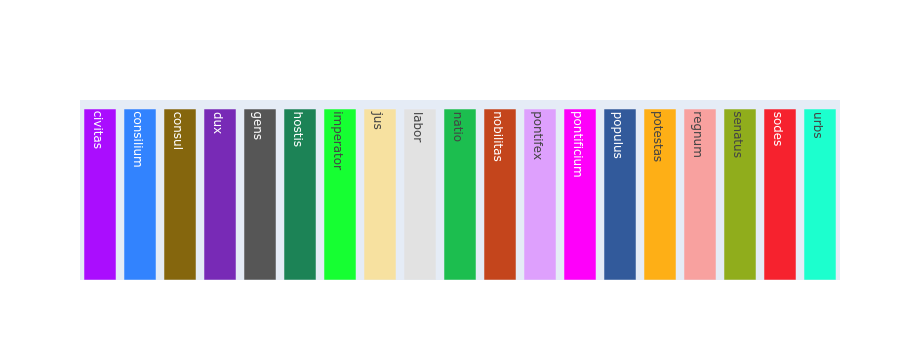

In [211]:
color_discrete_map_terms = { term : px.colors.qualitative.Alphabet[i] for i, term in enumerate(socio_political_terms)} # for each term we fix a color
fig = go.Figure()
fig.add_trace(go.Bar(
    x = [col for col in color_discrete_map_terms.keys()],
    y = [0.5 for x in range(0, len(color_discrete_map_terms)) ],
    text = socio_political_terms,
    textangle=90,
    marker_color=[col for col in color_discrete_map_terms.values()]
))
fig.update_layout(showlegend=False, xaxis={'showgrid': False, 'visible': False}, yaxis={'showgrid': False, 'visible': False})

## The corpus

The corpus processing phase follows as close as possible BMG's workflow to keep models compatible. There are 2 exceptions:

- all lemmas are converted to lowercase and
- anomalous lemmas (mostly punctuation) are added to stopword list.

In [212]:
# prepare the corpus
punctuation = ['.', ',', '...', ';', ':', '?', '(', ')', '-', '!', '[', ']', '"', "'", '""', '\n']

In [213]:
# corpus files
#dir_in = os.path.join("/home/krzys/Kod/streamlit/voces/data/corpora/latinise_IT_lemmas/")
dir_input =  os.path.join("/home/krzys/Kod/lvlt22/BMG/LatinISE_1/") # includes texts first omitted due to parsing issues
dir_in = os.path.join(dir_input, "preprocessed_lemmas")
dir_in_words = os.path.join(dir_input, "preprocessed_tokens")
files = os.listdir(os.path.join(dir_in))
files = [f for f in files[:] if "IT" in f]

#### Process the metadata
We'll be storing corpus metadata in a data frame.

In [214]:
# metadata (BMG)
metadata_df = pd.read_csv(os.path.join(dir_input, 'latinise_metadata.csv'), sep = ",")
metadata_df = metadata_df[metadata_df['id'].str.startswith("IT")]
metadata_df.head()
metadata_df["date"] = metadata_df["date"].astype('int') #ensure we're working with integers

In [215]:
first_date = min(metadata_df.date)

In [216]:
last_date = 900 # BMG

Define size of the time intervals:

In [217]:
size_interval = 450 # BMG

So there are

In [218]:
n_intervals = round((last_date-first_date)/size_interval) # BMG
n_intervals

3

time intervals.

Define the time periods and split the corpus:

In [219]:
intervals = [None]*(n_intervals+1) # BMG
for t in range(n_intervals+1):
    #print(t)
    if t == 0:
        intervals[t] = first_date
    else:
        intervals[t] = intervals[t-1]+size_interval
    #print(intervals[t])
    
print(intervals)
periods_labels = [ str(p1) + '-' + str(p2) for p1, p2 in zip(intervals, intervals[1:]) ]
print(periods_labels)

[-450, 0, 450, 900]
['-450-0', '0-450', '450-900']


Add a column to the metadata_df for the time interval:

In [220]:
metadata_df['time_interval'] = ""
for t in range(len(intervals)-1):
    print(t)
    print(range(intervals[t],intervals[t+1]))
    metadata_df_t = metadata_df.loc[metadata_df['date'].isin(range(intervals[t],intervals[t+1]))]
    print(metadata_df_t.date)
    metadata_df.loc[metadata_df['date'].isin(range(intervals[t],intervals[t+1])),'time_interval'] = intervals[t]
metadata_df

0
range(-450, 0)
19      -9
34     -49
39     -45
42     -49
57     -80
      ... 
635   -149
638   -107
642    -37
643    -37
649   -229
Name: date, Length: 77, dtype: int64
1
range(0, 450)
18     382
23     399
24     391
37     158
38      49
      ... 
682    382
683    116
684    116
685    116
686    116
Name: date, Length: 235, dtype: int64
2
range(450, 900)
20      524
102     800
104     800
105     800
106     800
       ... 
609     598
634     550
636     550
645     450
1265    533
Name: date, Length: 73, dtype: int64


,id,title,creator,date,type,file,time_interval
18,IT-LAT0001,Vulgata,Hieronymus,382,poetry,lat_0382_IT-LAT0001.txt,0
19,IT-LAT0537,Ars amatoria,"Ovidius Naso, Publius",-9,poetry,lat_-009_IT-LAT0537.txt,-450
20,IT-LAT0011,S. Benedicti Regula,Benedictus Nursianus,524,prose,lat_0524_IT-LAT0011.txt,450
21,IT-LAT0012,In psalmis Davidis expositio,Thomas Aquinas: Sanctus,1254,prose,lat_1254_IT-LAT0012.txt,
22,IT-LAT0014,Adoro te devote,Thomas Aquinas: Sanctus,1254,poetry,lat_1254_IT-LAT0014.txt,
...,...,...,...,...,...,...,...
683,IT-LAT0534_1,De origine et situ Germanorum,"Tacitus, Publius (Gaius) Cornelius",116,prose,lat_0116_IT-LAT0534_1.txt,0
684,IT-LAT0534_2,De vita Iulii Agricolae,"Tacitus, Publius (Gaius) Cornelius",116,prose,lat_0116_IT-LAT0534_2.txt,0
685,IT-LAT0534_3,Dialogus de oratoribus,"Tacitus, Publius (Gaius) Cornelius",116,prose,lat_0116_IT-LAT0534_3.txt,0
686,IT-LAT0534_4,Historiae,"Tacitus, Publius (Gaius) Cornelius",116,prose,lat_0116_IT-LAT0534_4.txt,0


In [221]:
def convert_dates(sign, date0):

    if sign == "0":
        if date0 == 0:
            final_date = "+0000"
        elif date0 < 100:
            final_date = "+" + "00" + str(date0)
            #print("1-final_date", final_date)
        elif date0 < 1000:
            final_date = "+" + "0" + str(date0)
            #print("2-final_date", final_date)
        else:
            final_date = "+" + str(date0)
            #print("3-final_date", final_date)
    else:
        if date0 == 0:
            final_date = "+0000"
        elif date0 < 100:
            final_date = str(sign) + "00" + str(date0)
            #print("1-final_date", final_date)
        elif date0 < 1000:
            final_date = str(sign) + "0" + str(date0)
            #print("2-final_date", final_date)
        else:
            final_date = str(sign) + str(date0)
            #print("3-final_date", final_date)

    if final_date.startswith("+"):
        final_date = final_date.replace("+", "")
    return final_date

### Read in corpus files

In [222]:
# prepare the corpus
punctuation = ['.', ',', '...', ';', ':', '?', '(', ')', '-', '!', '[', ']', '"', "'", '""', '\n', '']

In [223]:
# define corpus subset
corpus_subset = metadata_df[metadata_df['date'] <= last_date].copy().reset_index(drop=True)
filenames_subset = corpus_subset['file'] # filenames were defined above to get IT files only

In [224]:
from nltk.corpus.reader.plaintext import PlaintextCorpusReader, CategorizedPlaintextCorpusReader
from nltk.tokenize.simple import SpaceTokenizer, LineTokenizer
from nltk.text import Text, TextCollection
class NltkCorpusFromDirNew(PlaintextCorpusReader):
    "A subclass of NLTK PlaintextCorpusReader"
    
    word_tokenizer=SpaceTokenizer() # tokenize on whitespace
    sent_tokenizer=LineTokenizer() # assume sentence per line
    
    def __init__(
        self,
        root,
        fileids,
        encoding="utf8",        
        word_tokenizer=word_tokenizer,
        sent_tokenizer=sent_tokenizer,
        tolower=False, punctuation=None
    ):

        PlaintextCorpusReader.__init__(self, root=root, fileids=fileids, encoding=encoding,
                                       word_tokenizer=word_tokenizer,
                                       sent_tokenizer=sent_tokenizer)
        self.tolower = tolower
        self.punctuation = punctuation
        
    def _read_word_block(self, stream):
        words = []
        for i in range(20):  # Read 20 lines at a time.
            if self.punctuation is not None:
                words.extend( [ token.lower() if self.tolower == True else token for token 
                               in self._word_tokenizer.tokenize(stream.readline()) 
                               if token not in self.punctuation and token != '' 
                              ])
            else:
                words.extend( [ token.lower() if self.tolower == True else token for token in self._word_tokenizer.tokenize(stream.readline()) ])
        return words

In [225]:
#prepare the corpus
latinise = NltkCorpusFromDirNew(root=dir_in, fileids=filenames_subset,
                                punctuation=punctuation, tolower=True)
latinise_docs = []
for fileid in latinise.fileids():
    latinise_docs.append(Text(latinise.words(fileid)))
print("This corpus contains ", len(latinise_docs), " documents.")

This corpus contains  385  documents.


In [226]:
corpus = latinise

In `rebuild` mode we'll compile DSMs using Stephanie Evert's `R` package `wordspace`. If not otherwise stated, all terms used come from [the package's documentation](https://cran.r-project.org/web/packages/wordspace/wordspace.pdf).

In [228]:
if rebuild == True:
    #Let's compute cooccurrence counts in the corpus.
    window=2
    skip=0 # defines distance if skipgram
    ngrams = [ skipgrams(sent, window, skip) for sent in corpus.sents() ]
    ngram_counts = NgramCounter(ngrams)

In [234]:
# get triples (target, feature, freq) from the ngram_counts
coocs = []
if rebuild == True:
    for node, freqs in ngram_counts[window].items(): # dict_items([(('ars',), FreqDist({'et': 149, 'sum': 129, ...}}))])
        #print(word)
        for cooc, freq  in freqs.items():
            triple = (node[0], cooc, freq) # node term, cooc, freq
            coocs.append(triple)
    print(coocs[0:10])

In [235]:
# convert cooc counts to matrix
coocs_df = pd.DataFrame(coocs, columns=["target", "feature", "score"])
coocs_df.head()

,target,feature,score


In [236]:
if rebuild == True:
    # create dsm matrix
    VObj = wordspace.dsm(target=StrVector(coocs_df["target"]),
                         feature=StrVector(coocs_df["feature"]),
                         score=IntVector(coocs_df["score"]),
                         raw_freq=True) 
    print(VObj)

In [237]:
if rebuild == True:
    #default options
    config = dict(score="simple-ll", transform="log", normalize=True, method="euclidean", reduce_method="svd", reduce_n=100)
    print(config)
    VObj_weighted = wordspace.dsm_score(VObj, score=config["score"], transform=config["transform"], normalize=config["normalize"], method=config["method"])
    print(VObj_weighted)

In [238]:
if rebuild == True:
    VObj_weighted_reduced = wordspace.dsm_projection(VObj_weighted, method=config["reduce_method"], n=config["reduce_n"])
    print(VObj_weighted_reduced[0]) # takes around 5 mins

In [239]:
if rebuild == True:
    # save matrices to disk
    matrices = [VObj_weighted, VObj_weighted_reduced]
    import pickle
    f = open('dsm_matrices.model', 'wb')
    pickle.dump(matrices,f)

if rebuild == False:
    import pickle
    f = open('dsm_matrices.model', 'rb')
    matrices = pickle.load(f)
    VObj_weighted = matrices[0]
    VObj_weighted_reduced = matrices[1]

In [240]:
# get similar from unreduced space
[ print(term, "\n", wordspace.nearest_neighbours(VObj_weighted, term, n=10)) for term in socio_political_terms ]
# get similar from reduced space
[ print(term, "\n", wordspace.nearest_neighbours(VObj_weighted_reduced, term, n=10)) for term in socio_political_terms ]

civitas 
        urbs   provincia     urbibus       civis monasterium    libertas 
   78.82408    82.73842    82.91361    82.97710    83.21702    83.22212 
      finis       locus    imperium        gens 
   83.23276    83.32228    83.37032    83.43055 

consilium 
      ratio     animus sapienciam    fortuna auctoritas    amasius     amicus 
  81.47108   81.83400   81.89528   82.07157   82.18614   82.32734   82.34729 
  amicus#2   iudicium        vis 
  82.36571   82.42732   82.51315 

consul 
  praetor dictator Hispania   censor  curulis   Caesar     creo  collega 
73.45634 76.63352 78.54063 79.47254 79.64022 79.76030 80.04984 80.07877 
   plebs Hannibal 
80.11979 80.23867 

dux 
 exercitus     miles    consul  princeps     acies  Hispania   legatus   castrum 
 81.29878  82.87537  82.92559  83.24550  83.28065  83.47371  83.56196  83.57553 
 proelium    hostis 
 83.59564  83.60835 

gens 
         rex       natio   provincia     populus     civitas   exercitus 
   81.88972    82.17436

[None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None]

In [241]:
coocs_df.head()

,target,feature,score


In [242]:
# limit to f >= 5 words
threshold = 2
coocs_df_=coocs_df[coocs_df["score"] >= 5].copy()
if rebuild == True:
    # create dsm matrix
    VObj = wordspace.dsm(target=StrVector(coocs_df_["target"]),
                         feature=StrVector(coocs_df_["feature"]),
                         score=IntVector(coocs_df_["score"]),
                         raw_freq=True) 
    print(VObj)

In [243]:
if rebuild == True:
    
    #default options
    config = dict(score="simple-ll", transform="log", normalize=True, method="euclidean", reduce_method="svd", reduce_n=100)
    print(config)
    VObj_weighted = wordspace.dsm_score(VObj, score=config["score"], 
                                        transform=config["transform"], normalize=config["normalize"], method=config["method"],
                                       )
    print(VObj_weighted)

In [244]:
if rebuild == True:
    VObj_weighted_reduced = wordspace.dsm_projection(VObj_weighted, method=config["reduce_method"], n=config["reduce_n"])
    print(VObj_weighted_reduced[0]) # takes around 5 mins

In [246]:
if rebuild == True:
    # save matrices to disk
    matrices = [VObj_weighted, VObj_weighted_reduced]
    import pickle
    f = open('dsm_matrices_min5.model', 'wb')
    pickle.dump(matrices,f)

if rebuild == False:
    import pickle
    f = open('dsm_matrices_min5.model', 'rb')
    matrices = pickle.load(f)
    VObj_weighted = matrices[0]
    VObj_weighted_reduced = matrices[1]

EOFError: Ran out of input

In [247]:
# get similar from unreduced space
[ print(term, "\n", wordspace.nearest_neighbours(VObj_weighted, term, n=10)) for term in socio_political_terms ]
# get similar from reduced space
[ print(term, "\n", wordspace.nearest_neighbours(VObj_weighted_reduced, term, n=10)) for term in socio_political_terms ]

civitas 
        urbs   provincia     urbibus       civis monasterium    libertas 
   78.82408    82.73842    82.91361    82.97710    83.21702    83.22212 
      finis       locus    imperium        gens 
   83.23276    83.32228    83.37032    83.43055 

consilium 
      ratio     animus sapienciam    fortuna auctoritas    amasius     amicus 
  81.47108   81.83400   81.89528   82.07157   82.18614   82.32734   82.34729 
  amicus#2   iudicium        vis 
  82.36571   82.42732   82.51315 

consul 
  praetor dictator Hispania   censor  curulis   Caesar     creo  collega 
73.45634 76.63352 78.54063 79.47254 79.64022 79.76030 80.04984 80.07877 
   plebs Hannibal 
80.11979 80.23867 

dux 
 exercitus     miles    consul  princeps     acies  Hispania   legatus   castrum 
 81.29878  82.87537  82.92559  83.24550  83.28065  83.47371  83.56196  83.57553 
 proelium    hostis 
 83.59564  83.60835 

gens 
         rex       natio   provincia     populus     civitas   exercitus 
   81.88972    82.17436

[None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None]

### Splitting the corpus
The corpus is splitted into slices, each covering `size_interval` years.

In [248]:
# dictionary that maps a time interval with the list of sentences of texts in that time interval"
time2corpus = dict()

# I loop over all time intervals:
#for t in range(n_intervals+1): # remove redundant 900 interval
for t in range(n_intervals):
    files_corpus_t = list(corpus_subset.loc[corpus_subset['time_interval'] == intervals[t]]["file"])
    print("retrieving the subcorpus for interval ", intervals[t])
    sents = latinise.sents(fileids=files_corpus_t)
    sents_clean = list()
    for sent in sents:
        sents_clean.append( [ token.lower()  for token in sent if token not in punctuation and token != ''  ] )
    time2corpus[t] = sents_clean

retrieving the subcorpus for interval  -450
retrieving the subcorpus for interval  0
retrieving the subcorpus for interval  450


The `time2corpus` variable is a dictionary with time slices as keys. Each item is a list of sentences, each being a list of lemmas.

In [249]:
print(f'Dictionary keys are: { [ period for period in time2corpus.keys()] }')
print('First 3 sentences from the 3rd corpus slice are: ', time2corpus[2][0:2])

Dictionary keys are: [0, 1, 2]
First 3 sentences from the 3rd corpus slice are:  [['obsculta', 'o', 'filius', 'praeceptum', 'magister', 'et', 'inclino', 'auris', 'cor', 'tuus', 'et', 'admonitio', 'pius', 'pater', 'libet', 'excipe', 'et', 'efficaciter', 'comple', 'ut', 'ad', 'is', 'per', 'oboedientia', 'labor', 'redeo', 'ab', 'quo', 'per', 'inoboedientia', 'desidia', 'recedo'], ['ad', 'tu', 'ergo', 'nunc', 'ego', 'sermo', 'dirigo', 'quisquis', 'abrenuntio', 'proprius', 'voluntas', 'dominus', 'christus', 'verus', 'rex', 'militaturus', 'oboedientia', 'fortis', 'atque', 'praeclarus', 'arma', 'sumo']]


In [250]:
time2corpus[2][0:1]

[['obsculta',
  'o',
  'filius',
  'praeceptum',
  'magister',
  'et',
  'inclino',
  'auris',
  'cor',
  'tuus',
  'et',
  'admonitio',
  'pius',
  'pater',
  'libet',
  'excipe',
  'et',
  'efficaciter',
  'comple',
  'ut',
  'ad',
  'is',
  'per',
  'oboedientia',
  'labor',
  'redeo',
  'ab',
  'quo',
  'per',
  'inoboedientia',
  'desidia',
  'recedo']]

In [251]:
if rebuild == True:
    window=2
    skip=0 # defines distance if skipgram
    # DSM options
    config = dict(score="Dice", transform="log", normalize=True, method="euclidean", reduce_method="svd", reduce_n=300)
    models = dict.fromkeys(range(len(time2corpus)))
    #models

In [252]:
if rebuild == True:
    start = time.time()
    for t in range(len(time2corpus)):
        if len(time2corpus[t])>0:
            print("Building model for t = ", t, "\n")

            print("Retrieving coocurrence counts for t = ", t, "\n")
            #prepare coocs
            ngrams = [ skipgrams(sent, window, skip) for sent in time2corpus[t] ]
            ngram_counts = NgramCounter(ngrams)

            print("Retrieving (target, feature, freq) from the ngram_counts for t = ", t, "\n")
            # get triples (target, feature, freq) from the ngram_counts
            coocs = []
            for node, freqs in ngram_counts[window].items(): # dict_items([(('ars',), FreqDist({'et': 149, 'sum': 129, ...}}))])
                for cooc, freq  in freqs.items():
                    triple = (node[0], cooc, freq) # node term, cooc, freq
                    coocs.append(triple)

            coocs_df = pd.DataFrame(coocs, columns=["target", "feature", "score"])
            #coocs_df.head()

            print("Building DSM matrices for t = ", t, "\n")

            # create dms matrix
            VObj = wordspace.dsm(target=StrVector(coocs_df["target"]),
                                 feature=StrVector(coocs_df["feature"]),
                                 score=IntVector(coocs_df["score"]),
                                 raw_freq=True) 
            VObj_weighted = wordspace.dsm_score(VObj, score=config["score"], transform=config["transform"], normalize=config["normalize"], method=config["method"])
            VObj_weighted_reduced = wordspace.dsm_projection(VObj_weighted, method=config["reduce_method"], n=config["reduce_n"])

            print("Saving models for t = ", t, "\n")
            models[t] = (VObj_weighted, VObj_weighted_reduced)

    end = time.time()
    print("It has taken", round(end - start), "seconds, or ", round((end - start)/60), "minutes")

In [253]:
if rebuild == True:
    # save diachronic models to disk
    import pickle
    with open('dsm_matrices_time.model', 'wb') as f:
        pickle.dump(models,f)

In [254]:
if rebuild == False:
    #load models from disk
    import pickle
    with open('dsm_matrices_time.model', 'rb') as f:
        models = pickle.load(f)

In [255]:
# get similarity counts
for t, model in models.items():
    if model is not None:
        print("Similarities for t =", t)
        print("Unreduced matrix for t =", t)    
        [ print(term, "\n", wordspace.nearest_neighbours(model[0], term, n=10) 
                if term in list(models[t][0].rx2('rows').rx2("term")) else None)
         for term in socio_political_terms ]
        print("Reduced matrix for t =", t)
        [ print(term, "\n", wordspace.nearest_neighbours(model[1], term, n=10)  
                if term in list(models[t][0].rx2('rows').rx2("term")) else None) 
         for term in socio_political_terms ]

Similarities for t = 0
Unreduced matrix for t = 0
civitas 
          publicus         nutricius           luceres        finibusque 
         80.56111          81.75975          81.75975          81.85357 
immortalitatemque          minvitis         cassianae    commentariolis 
         81.92099          81.92099          81.92099          81.92819 
            civis           fortuna 
         81.95777          82.17159 

consilium 
      caedisque       arrenius        praemia         emunio      veneratio 
      80.42224       80.42224       80.42224       81.31734       81.34217 
    liberumque         socero     mulciberis      siliculam coniecturamque 
      81.48890       81.89367       81.97982       81.97982       81.97982 

consul 
   praetor  dictator provincia      creo      roma     annus  hispania    gallia 
 74.66979  77.81771  78.37224  79.22149  79.23862  79.60078  79.76189  79.88086 
   censor   sicilia 
 80.12092  80.41696 

dux 
        imperator       inferentem   

## Aligning vector spaces

In [256]:
reference_interval = "last"

In [257]:
def find_reference_intervals(reference_step, intervals):
    
    if reference_step == "first":
        #range_intervals = range(intervals[1], intervals[len(intervals)-1], size_interval)
        #range_intervals_index = range(1, len(intervals)-1)
        #reference_interval = intervals[0]
        reference_interval_index = 0
    elif reference_step == "last":
        #range_intervals = range(intervals[0], intervals[len(intervals)-2], size_interval)
        #range_intervals_index = range(0, len(intervals)-2)
        #reference_interval = intervals[len(intervals)-1]
        reference_interval_index = len(intervals)-2
        
    #return (range_intervals, range_intervals_index, reference_interval, reference_interval_index)
    return reference_interval_index

In [258]:
find_reference_intervals("first", intervals)

0

In [259]:
find_reference_intervals("last", intervals)

2

We're extracting vectors from the R objects created with wordspace and saving them as dfs indexed with lemmas (the column names are svd_1..svd_dimensions).

In [260]:
if rebuild == True:
    import pandas as pd
    import rpy2.robjects as ro
    from rpy2.robjects.packages import importr
    from rpy2.robjects import pandas2ri
    from rpy2.robjects.conversion import localconverter

    models_dfs = {}
    for period in models.keys():
        if models[period] is None:
            print(period, " is None")
            continue
        else:
            print(period)
            models_dfs.setdefault(period, pd.DataFrame())
            with localconverter(ro.default_converter + pandas2ri.converter):
                model_arr = ro.conversion.rpy2py(models[period][1])        
            model_df = pd.DataFrame(model_arr)
            model_df.index = models[period][1].names[0]
            model_df.columns = models[period][1].names[1]
            models_dfs[period] = model_df
        
    import pickle
    with open('dsm_matrices_time_dfs.pickle', 'wb') as f:
        pickle.dump(models_dfs,f)

if rebuild == False:
    import pickle
    with open('dsm_matrices_time_dfs.pickle', 'rb') as f:
        models_dfs = pickle.load(f)

Let's inspect the data.

In [261]:
for i, df in enumerate(models_dfs.values()):
    print('interval: ', i, ' shape: ', df.shape)
models_dfs[0].head()

interval:  0  shape:  (41239, 300)
interval:  1  shape:  (93005, 300)
interval:  2  shape:  (48661, 300)


,svd1,svd2,svd3,svd4,svd5,svd6,svd7,svd8,svd9,svd10,...,svd291,svd292,svd293,svd294,svd295,svd296,svd297,svd298,svd299,svd300
ars,0.035904,-0.033766,0.033105,-0.090521,0.011562,-0.056791,0.085019,-0.076952,-0.005704,-0.008261,...,0.012634,0.000133,0.019356,-0.017239,-0.022201,0.013907,-0.007278,0.015079,0.026673,-0.010085
amatorius,0.000764,-0.000690,0.000650,-0.000644,0.000745,-0.002324,0.002565,-0.001644,0.000561,-0.000399,...,0.005135,-0.005108,-0.000074,-0.001027,0.013011,0.009594,-0.002989,0.000453,-0.000361,0.011359
siquis,0.033472,-0.105847,0.184156,-0.189369,-0.026718,0.000651,0.011539,-0.009925,0.016356,-0.023778,...,-0.004650,-0.029118,-0.006586,-0.005285,-0.000277,0.008291,-0.012955,-0.009770,-0.003774,0.002435
in,0.015664,-0.016560,0.023768,-0.017405,0.083961,-0.029878,0.035149,-0.013833,0.017239,-0.010521,...,-0.016275,0.019981,-0.029441,-0.023253,0.014445,-0.017572,-0.011895,-0.001414,-0.018207,-0.004803
hic,0.015821,-0.016160,0.019236,-0.015777,0.018288,-0.044468,0.041649,-0.016763,0.022149,-0.012644,...,-0.009105,0.033675,-0.005186,0.000451,-0.015449,-0.019207,-0.043906,-0.022710,0.018609,-0.006369


In [262]:
def intersection_align_wordspace(m1, m2, words=None): # modified version of the gensim-based code
    """
    Intersect two wordspace count models, m1 and m2.
    Only the shared vocabulary between them is kept.
    If 'words' is set (as list or set), then the vocabulary is intersected with this list as well.
    Indices are re-organized from 0..N in order of descending frequency (=sum of counts from both m1 and m2).
    These indices correspond to the new syn0 and syn0norm objects in both gensim models:
        -- so that Row 0 of m1.syn0 will be for the same word as Row 0 of m2.syn0
        -- you can find the index of any word on the .index2word list: model.index2word.index(word) => 2
    The .vocab dictionary is also updated for each model, preserving the count but updating the index.
    """

    # Get the vocab for each model
    vocab_m1 = set(m1.index)
    vocab_m2 = set(m2.index)

    # Find the common vocabulary
    common_vocab = vocab_m1 & vocab_m2
    if words: common_vocab &= set(words)

    # If no alignment necessary because vocab is identical...
    if not vocab_m1 - common_vocab and not vocab_m2 - common_vocab:
        return (common_vocab, m1,m2)

    # Otherwise sort by frequency (summed for both)
    common_vocab = list(common_vocab)
    #common_vocab.sort(key=lambda w: m1.wv.get_vecattr(w, "count") + m2.wv.get_vecattr(w, "count"), reverse=True) # KN: no sorting needed
    # print(len(common_vocab))

    # Then for each model...
    m1 = m1.loc[common_vocab]
    m2 = m2.loc[common_vocab]
    
    return (common_vocab, m1, m2)

As we don't have time now to modify `wordspace` `R` objects we'll be working with numpy arrays and convert them to lemma-indexed pandas dfs. For testing purposes, let's intersect first and reference matrix.

In [263]:
common, m1, m2 = intersection_align_wordspace(models_dfs[0], models_dfs[find_reference_intervals(reference_interval, intervals)])
print(m1.shape, m2.shape)
m1.shape == m2.shape

(14226, 300) (14226, 300)


True

In [264]:
import numpy as np
def smart_procrustes_align_wordspace(base_embed, other_embed, words=None):
    """
    Original script: https://gist.github.com/quadrismegistus/09a93e219a6ffc4f216fb85235535faf
    Procrustes align two gensim word2vec models (to allow for comparison between same word across models).
    Code ported from HistWords <https://github.com/williamleif/histwords> by William Hamilton <wleif@stanford.edu>.
        
    First, intersect the vocabularies (see `intersection_align_gensim` documentation).
    Then do the alignment on the other_embed model.
    Replace the other_embed model's syn0 and syn0norm numpy matrices with the aligned version.
    Return other_embed.
    If `words` is set, intersect the two models' vocabulary with the vocabulary in words (see `intersection_align_gensim` documentation).
    """

    # make sure vocabulary and indices are aligned
    if words is not None:
        in_base_embed, in_other_embed = base_embed.loc[words], other_embed.loc[words]
    else:
        common_vocab, in_base_embed, in_other_embed = intersection_align_wordspace(base_embed, other_embed, words=words)

    # re-filling the normed vectors: the following two lines were added following Japleen Gulati, following amacanovic's comments n the discussion below this page: https://gist.github.com/zhicongchen/9e23d5c3f1e5b1293b16133485cd17d8
    # we don't need this step as we're working on matrices and not gensim objects
    #in_base_embed.wv.fill_norms(force=True)
    #in_other_embed.wv.fill_norms(force=True)
    
    # get the (normalized) embedding matrices
    #base_vecs = in_base_embed.wv.get_normed_vectors()
    #other_vecs = in_other_embed.wv.get_normed_vectors()
    base_vecs = in_base_embed # just a copy
    other_vecs = in_other_embed
    #print(base_vecs.shape)
    #print(other_vecs.shape)


    # just a matrix dot product with numpy
    m = other_vecs.T.dot(base_vecs) 
    # SVD method from numpy
    u, _, v = np.linalg.svd(m)
    # another matrix operation
    ortho = u.dot(v) 
    # Replace original array with modified one, i.e. multiplying the embedding matrix by "ortho"
    other_embed = (other_vecs).dot(ortho)    
    
    return (other_embed, base_vecs) # we return base as well for the last


Alternatively, we may first compute common vocabulary and subset dfs.

In [265]:
common_vocab = list(set.intersection(*[set(df.index) for df in models_dfs.values()]))
print(len(common_vocab))
test = smart_procrustes_align_wordspace(models_dfs[2], models_dfs[0], words=common_vocab)
test[0].head()
test[1].head()

13357


,svd1,svd2,svd3,svd4,svd5,svd6,svd7,svd8,svd9,svd10,...,svd291,svd292,svd293,svd294,svd295,svd296,svd297,svd298,svd299,svd300
occultum,0.000611,-0.000413,0.000691,-0.000190,0.001426,-0.001200,0.001526,-0.000304,0.000066,-0.001016,...,0.004475,0.008238,-0.021701,0.014730,-0.015420,-0.020257,-0.041211,0.009209,-0.021187,0.035164
vitellius,0.013795,-0.030046,0.215699,-0.274113,-0.009538,0.002279,0.002369,-0.002494,0.002287,-0.009113,...,-0.004071,-0.004840,-0.005347,0.003790,0.001042,0.007990,-0.001533,-0.004834,0.002435,-0.003967
densitas,0.009988,-0.024317,0.200176,-0.260488,-0.013713,0.013258,-0.010766,0.007219,-0.001432,0.001263,...,0.004372,-0.000779,0.002678,0.002382,0.001901,0.004163,-0.001514,0.002465,-0.000327,0.000281
helena,0.004748,-0.006913,0.012152,-0.000494,0.133126,0.002023,0.005914,-0.009337,0.005139,-0.000876,...,0.006982,-0.010035,-0.006032,0.000474,-0.005821,0.005024,-0.010477,-0.000615,-0.001493,-0.012529
otus,0.032419,-0.571639,-0.051041,0.007034,-0.007110,0.003109,0.007235,-0.015264,0.020743,-0.002356,...,0.000223,0.000341,-0.000228,0.000002,0.001068,0.000895,-0.001211,-0.001078,-0.000080,-0.000420


In [266]:
models_dfs_aligned = []

if reference_interval == 'last':
    ri_pos = find_reference_intervals('last', intervals)
    for i in range(0,ri_pos):
        if i + 1 < ri_pos:
            print('interval: ', i, ' comparing with: ', ri_pos)
            models_dfs_aligned.append(
                smart_procrustes_align_wordspace(models_dfs[ri_pos], models_dfs[i], words=common_vocab)[0]
            )
        else:
            # if we're processing the n-1 model we're returning both the aligned and the base model
            print('interval: ', i, ' comparing with: ', ri_pos, ' and returning the last')
            models_dfs_aligned.extend(
                smart_procrustes_align_wordspace(models_dfs[ri_pos], 
                                                 models_dfs[i], words=common_vocab) 
                
            )
    

interval:  0  comparing with:  2
interval:  1  comparing with:  2  and returning the last


Let's check the shape of the aligned matrices.

In [267]:
for i, df in enumerate(models_dfs_aligned):
    print('interval: ', i, ' shape: ', df.shape)

interval:  0  shape:  (13357, 300)
interval:  1  shape:  (13357, 300)
interval:  2  shape:  (13357, 300)


In [268]:
models_dfs[2].head()

,svd1,svd2,svd3,svd4,svd5,svd6,svd7,svd8,svd9,svd10,...,svd291,svd292,svd293,svd294,svd295,svd296,svd297,svd298,svd299,svd300
obsculta,0.000336,-0.000315,0.000866,-0.000370,0.000636,-0.001004,0.000832,-0.000647,0.000421,-0.000416,...,-0.003202,-0.000162,-0.007241,-0.002474,0.002161,0.005489,0.005012,0.002103,0.005528,0.005633
o,0.006629,-0.007695,0.012920,-0.000947,0.013171,-0.029614,0.027726,-0.029617,0.022927,-0.004174,...,-0.010550,0.002613,0.002907,-0.012935,0.030703,0.005495,0.001769,-0.015200,-0.004247,-0.022035
filius,0.055418,-0.010375,0.036957,0.015338,0.110553,-0.021381,0.029105,-0.041812,0.014222,-0.084927,...,-0.011664,0.014972,0.002515,-0.005093,-0.006259,0.005242,-0.001247,-0.005842,-0.011803,0.002596
praeceptum,0.016347,-0.155519,0.036532,0.028199,0.017670,-0.055918,0.021817,-0.032915,0.013451,-0.064348,...,0.007013,-0.027641,-0.013421,-0.033266,0.018207,-0.008623,0.002263,-0.027482,0.016502,-0.004379
magister,0.040853,-0.005320,0.030483,0.019731,0.005312,-0.010939,0.010477,-0.009937,0.003156,-0.011236,...,0.017829,-0.022711,0.003936,-0.035751,0.019111,0.004216,0.011162,-0.001161,-0.012895,0.006315


In [269]:
test = smart_procrustes_align_wordspace(models_dfs[2], models_dfs[0])[1]
test.shape

(14226, 300)

# Semantic change with cosine similarity

Let's define a function that calculates the cosine similarity between the embedding of a word in a time interval t and the embedding of the same word in the reference time interval:

In [270]:
from scipy import spatial
def cosine_similarity_wordspace(word, t, reference_step, models, intervals):
    reference_interval_index = find_reference_intervals(reference_step, intervals)
    sc = np.nan
    if models[reference_interval_index] is None:
        print("Model of reference interval is empty!")
    else:
        if models[t] is not None:
            sc = 1-spatial.distance.cosine(models[t].loc[word], models[reference_interval_index].loc[word])
    return sc

In [271]:
cosine_similarity_wordspace("sum", 2, "last", models_dfs_aligned, intervals)

1

In [272]:
models_dfs_aligned[0].loc["sum"]

0      0.086197
1     -0.034015
2      0.079087
3      0.000300
4      0.065735
         ...   
295    0.028824
296    0.001180
297   -0.007238
298    0.005301
299   -0.012873
Name: sum, Length: 300, dtype: float64

In [273]:
cosine_similarity_wordspace("sum", 2, "first", models_dfs_aligned, intervals)

0.7726729865576175

Now I define a function that, given a reference step and a time interval index (starting from 0 for the first model), calculates the semantic similarity for all words in the vocabulary between these two time intervals, and stores this in the dataframe cosine_similarity_df:

In [274]:
def cosine_similarity_dataframe(reference_step, time_interval_index, models, intervals):
    if time_interval_index<0 or time_interval_index>len(models)-1:
        print("Second argument needs to be between 0 and ", len(models)-1)
        
    reference_interval_index = find_reference_intervals(reference_step, intervals)
    #print(reference_interval_index)
    if models[reference_interval_index] is not None and models[time_interval_index] is not None:
        cosine_similarity_df = pd.DataFrame(([w, 
            models[reference_interval_index].loc[w],
            models[time_interval_index].loc[w],
            cosine_similarity_wordspace(w,time_interval_index, reference_step, models, intervals)  
            ] for w in models[time_interval_index].index), 
        columns = ('Word', "Frequency_t_reference-"+str(reference_step), "Frequency_t"+str(time_interval_index), 
        'Cosine_similarity(w_t_reference-'+str(reference_step)+',w_t'+str(time_interval_index)+')'))
    else:
        print("The reference model or the current model are empty!")
        cosine_similarity_df = pd.DataFrame()
    return cosine_similarity_df

In [275]:
cosine_similarity_dataframe("last", 0, models_dfs_aligned, intervals)

,Word,Frequency_t_reference-last,Frequency_t0,"Cosine_similarity(w_t_reference-last,w_t0)"
0,occultum,svd1 0.000611 svd2 -0.000413 svd3 ...,0 0.049388 1 -0.053028 2 -0.04306...,0.120571
1,vitellius,svd1 0.013795 svd2 -0.030046 svd3 ...,0 0.008974 1 -0.207092 2 -0.01823...,0.052794
2,densitas,svd1 0.009988 svd2 -0.024317 svd3 ...,0 -0.000458 1 -0.000823 2 -0.00051...,0.093131
3,helena,svd1 0.004748 svd2 -0.006913 svd3 ...,0 -0.000169 1 0.002112 2 0.00086...,0.263685
4,otus,svd1 0.032419 svd2 -0.571639 svd3 ...,0 0.096003 1 -0.016870 2 0.04573...,0.202788
...,...,...,...,...
13352,adversus#2,svd1 0.008160 svd2 -0.013810 svd3 ...,0 0.010624 1 -0.014546 2 0.04082...,0.425430
13353,minuo,svd1 0.138794 svd2 -0.065837 svd3 ...,0 0.061418 1 -0.036195 2 0.10615...,0.357412
13354,insectatio,svd1 0.000287 svd2 -0.000566 svd3 ...,0 0.119706 1 -0.135181 2 0.06066...,-0.007820
13355,victus,svd1 0.320747 svd2 0.013005 svd3 ...,0 0.082038 1 -0.002731 2 0.00335...,0.117998


In [276]:
cosine_similarity_dataframe("last", 1, models_dfs_aligned, intervals)

,Word,Frequency_t_reference-last,Frequency_t1,"Cosine_similarity(w_t_reference-last,w_t1)"
0,occultum,svd1 0.000611 svd2 -0.000413 svd3 ...,0 0.057747 1 -0.003498 2 0.01481...,0.160628
1,vitellius,svd1 0.013795 svd2 -0.030046 svd3 ...,0 0.011762 1 -0.024718 2 0.02160...,0.280230
2,densitas,svd1 0.009988 svd2 -0.024317 svd3 ...,0 0.005619 1 -0.011434 2 0.03467...,0.029247
3,helena,svd1 0.004748 svd2 -0.006913 svd3 ...,0 0.037712 1 -0.035254 2 0.07296...,0.343416
4,otus,svd1 0.032419 svd2 -0.571639 svd3 ...,0 0.016564 1 -0.201183 2 -0.01869...,0.294229
...,...,...,...,...
13352,adversus#2,svd1 0.008160 svd2 -0.013810 svd3 ...,0 0.015334 1 -0.024311 2 0.05375...,0.459484
13353,minuo,svd1 0.138794 svd2 -0.065837 svd3 ...,0 0.115570 1 -0.026517 2 0.02925...,0.430746
13354,insectatio,svd1 0.000287 svd2 -0.000566 svd3 ...,0 0.066619 1 -0.015601 2 0.02308...,0.026503
13355,victus,svd1 0.320747 svd2 0.013005 svd3 ...,0 0.056841 1 -0.017338 2 0.00480...,0.194563


Visualise the distribution of the semantic similarity scores with a histogram:

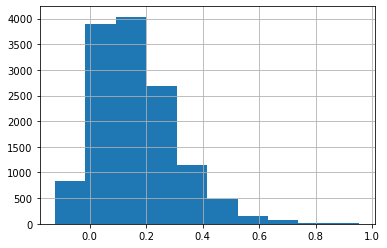

In [277]:
#hist = cosine_similarity_df['Cosine_similarity(w_t0,w_t1)'].hist()
# I display the last column of the data frame:
hist = cosine_similarity_dataframe("last", 0, models_dfs_aligned, intervals).iloc[:,-1].hist()

Now I can store the full time series of the cosine similarity between the embedding of a word in each time interval and the embedding of that same word in the reference interval (set to "last"):

In [278]:
intervals

[-450, 0, 450, 900]

In [279]:
reference_step = "last"
time_series = list()
reference_interval_index = find_reference_intervals(reference_step, intervals)
time_series_df = pd.DataFrame()

df = cosine_similarity_dataframe(reference_step, reference_interval_index, models_dfs_aligned, intervals)
time_series_df[df.columns[0]] = df.iloc[:,0]
time_series_df[df.columns[1]] = df.iloc[:,1]

In [280]:
models_dfs_aligned[0].loc["civitas"]

0      0.023874
1     -0.092846
2      0.050757
3      0.009857
4      0.012210
         ...   
295   -0.004311
296    0.027298
297   -0.009368
298    0.005146
299   -0.019080
Name: civitas, Length: 300, dtype: float64

In [281]:
time_series_df.keys()

Index(['Word', 'Frequency_t_reference-last'], dtype='object')

In [282]:
for i in range(len(models_dfs_aligned)):
    #print(reference_interval_index)
    print("Interval", str(intervals[i]), "with", str(list(intervals)[reference_interval_index]))
    df = cosine_similarity_dataframe(reference_step, i, models_dfs_aligned, intervals)
    if i != reference_interval_index:
        tmp_df = df.iloc[:,-2:]
        #df.iloc[:,-2:].column[0]
        #print(df.iloc[:,0])
        time_series_df[tmp_df.columns[0]] = tmp_df.iloc[:,0]
        time_series_df[tmp_df.columns[1]] = tmp_df.iloc[:,1]
        col_i = "interval-"+str(i)
        time_series_df[col_i] = [i for w in models_dfs_aligned[reference_interval_index].index]
        #Finding top 10 nearest neighbours:
        col_n = "neighbours_t"+str(i)
        #KN: resolve time_series_df[col_n] = [models_dfs_aligned[i].wv.similar_by_word(w, 10) for w in models_dfs_aligned[i].index]
        #print(time_series_df)
    else:
        tmp_df = df.iloc[:,-2:]
        #df.iloc[:,-2:].column[0]
        #print(df.iloc[:,0])
        time_series_df[tmp_df.columns[0]] = tmp_df.iloc[:,0]
        time_series_df[tmp_df.columns[1]] = tmp_df.iloc[:,1]
        col_i = "interval-"+str(i)
        time_series_df[col_i] = [i for w in models_dfs_aligned[reference_interval_index].index]
        #Finding top 10 nearest neighbours:
        col_n = "neighbours_t"+str(i)
        #KN: resolve time_series_df[col_n] = [models[i].wv.similar_by_word(w, 10) for w in models[i].wv.index_to_key]
    
time_series_df

Interval -450 with 450
Interval 0 with 450
Interval 450 with 450


,Word,Frequency_t_reference-last,Frequency_t0,"Cosine_similarity(w_t_reference-last,w_t0)",interval-0,Frequency_t1,"Cosine_similarity(w_t_reference-last,w_t1)",interval-1,Frequency_t2,"Cosine_similarity(w_t_reference-last,w_t2)",interval-2
0,occultum,svd1 0.000611 svd2 -0.000413 svd3 ...,0 0.049388 1 -0.053028 2 -0.04306...,0.120571,0,0 0.057747 1 -0.003498 2 0.01481...,0.160628,1,svd1 0.000611 svd2 -0.000413 svd3 ...,1,2
1,vitellius,svd1 0.013795 svd2 -0.030046 svd3 ...,0 0.008974 1 -0.207092 2 -0.01823...,0.052794,0,0 0.011762 1 -0.024718 2 0.02160...,0.280230,1,svd1 0.013795 svd2 -0.030046 svd3 ...,1,2
2,densitas,svd1 0.009988 svd2 -0.024317 svd3 ...,0 -0.000458 1 -0.000823 2 -0.00051...,0.093131,0,0 0.005619 1 -0.011434 2 0.03467...,0.029247,1,svd1 0.009988 svd2 -0.024317 svd3 ...,1,2
3,helena,svd1 0.004748 svd2 -0.006913 svd3 ...,0 -0.000169 1 0.002112 2 0.00086...,0.263685,0,0 0.037712 1 -0.035254 2 0.07296...,0.343416,1,svd1 0.004748 svd2 -0.006913 svd3 ...,1,2
4,otus,svd1 0.032419 svd2 -0.571639 svd3 ...,0 0.096003 1 -0.016870 2 0.04573...,0.202788,0,0 0.016564 1 -0.201183 2 -0.01869...,0.294229,1,svd1 0.032419 svd2 -0.571639 svd3 ...,1,2
...,...,...,...,...,...,...,...,...,...,...,...
13352,adversus#2,svd1 0.008160 svd2 -0.013810 svd3 ...,0 0.010624 1 -0.014546 2 0.04082...,0.425430,0,0 0.015334 1 -0.024311 2 0.05375...,0.459484,1,svd1 0.008160 svd2 -0.013810 svd3 ...,1,2
13353,minuo,svd1 0.138794 svd2 -0.065837 svd3 ...,0 0.061418 1 -0.036195 2 0.10615...,0.357412,0,0 0.115570 1 -0.026517 2 0.02925...,0.430746,1,svd1 0.138794 svd2 -0.065837 svd3 ...,1,2
13354,insectatio,svd1 0.000287 svd2 -0.000566 svd3 ...,0 0.119706 1 -0.135181 2 0.06066...,-0.007820,0,0 0.066619 1 -0.015601 2 0.02308...,0.026503,1,svd1 0.000287 svd2 -0.000566 svd3 ...,1,2
13355,victus,svd1 0.320747 svd2 0.013005 svd3 ...,0 0.082038 1 -0.002731 2 0.00335...,0.117998,0,0 0.056841 1 -0.017338 2 0.00480...,0.194563,1,svd1 0.320747 svd2 0.013005 svd3 ...,1,2


Print to a file:

In [283]:
time_series_df.to_csv(os.path.join('.', 'semantic_change_'+str(size_interval)+'_allwords.csv'), index=None)

In [284]:
time_series_df.columns

Index(['Word', 'Frequency_t_reference-last', 'Frequency_t0',
       'Cosine_similarity(w_t_reference-last,w_t0)', 'interval-0',
       'Frequency_t1', 'Cosine_similarity(w_t_reference-last,w_t1)',
       'interval-1', 'Frequency_t2',
       'Cosine_similarity(w_t_reference-last,w_t2)', 'interval-2'],
      dtype='object')

In [285]:
time_series_df[['interval-0', 'Cosine_similarity(w_t_reference-last,w_t0)']]

,interval-0,"Cosine_similarity(w_t_reference-last,w_t0)"
0,0,0.120571
1,0,0.052794
2,0,0.093131
3,0,0.263685
4,0,0.202788
...,...,...
13352,0,0.425430
13353,0,0.357412
13354,0,-0.007820
13355,0,0.117998


In [286]:
time_series_df[['interval-0', 'Cosine_similarity(w_t_reference-last,w_t0)']].describe

<bound method NDFrame.describe of        interval-0  Cosine_similarity(w_t_reference-last,w_t0)
0               0                                    0.120571
1               0                                    0.052794
2               0                                    0.093131
3               0                                    0.263685
4               0                                    0.202788
...           ...                                         ...
13352           0                                    0.425430
13353           0                                    0.357412
13354           0                                   -0.007820
13355           0                                    0.117998
13356           0                                   -0.053624

[13357 rows x 2 columns]>

In [287]:
time_series_df[['interval-1', 'Cosine_similarity(w_t_reference-last,w_t1)']]

,interval-1,"Cosine_similarity(w_t_reference-last,w_t1)"
0,1,0.160628
1,1,0.280230
2,1,0.029247
3,1,0.343416
4,1,0.294229
...,...,...
13352,1,0.459484
13353,1,0.430746
13354,1,0.026503
13355,1,0.194563


In [288]:
time_series_df[['Cosine_similarity(w_t_reference-last,w_t0)',
                           'Cosine_similarity(w_t_reference-last,w_t1)'
               ]].iloc[0]

Cosine_similarity(w_t_reference-last,w_t0)    0.120571
Cosine_similarity(w_t_reference-last,w_t1)    0.160628
Name: 0, dtype: float64

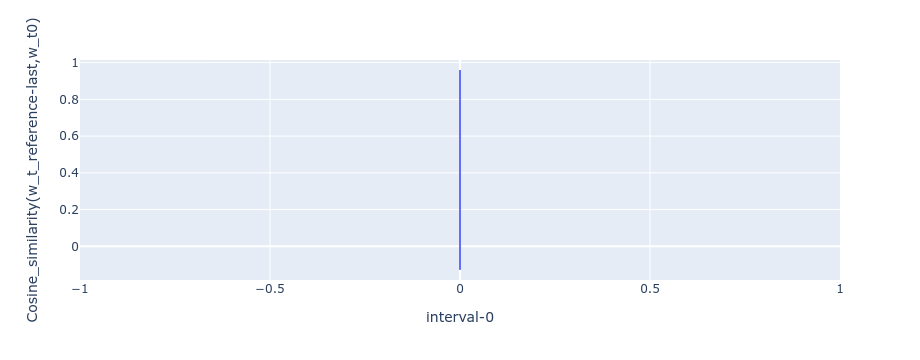

In [289]:
px.line(time_series_df[['interval-0', 'Cosine_similarity(w_t_reference-last,w_t0)']], 
        x = 'interval-0', y = 'Cosine_similarity(w_t_reference-last,w_t0)')

In [114]:
time_series_df

,Word,Frequency_t_reference-last,Frequency_t0,"Cosine_similarity(w_t_reference-last,w_t0)",interval-0,Frequency_t1,"Cosine_similarity(w_t_reference-last,w_t1)",interval-1,Frequency_t2,"Cosine_similarity(w_t_reference-last,w_t2)",interval-2
0,occultum,svd1 0.000611 svd2 -0.000413 svd3 ...,0 0.049388 1 -0.053028 2 -0.04306...,0.120571,0,0 0.057747 1 -0.003498 2 0.01481...,0.160628,1,svd1 0.000611 svd2 -0.000413 svd3 ...,1,2
1,vitellius,svd1 0.013795 svd2 -0.030046 svd3 ...,0 0.008974 1 -0.207092 2 -0.01823...,0.052794,0,0 0.011762 1 -0.024718 2 0.02160...,0.280230,1,svd1 0.013795 svd2 -0.030046 svd3 ...,1,2
2,densitas,svd1 0.009988 svd2 -0.024317 svd3 ...,0 -0.000458 1 -0.000823 2 -0.00051...,0.093131,0,0 0.005619 1 -0.011434 2 0.03467...,0.029247,1,svd1 0.009988 svd2 -0.024317 svd3 ...,1,2
3,helena,svd1 0.004748 svd2 -0.006913 svd3 ...,0 -0.000169 1 0.002112 2 0.00086...,0.263685,0,0 0.037712 1 -0.035254 2 0.07296...,0.343416,1,svd1 0.004748 svd2 -0.006913 svd3 ...,1,2
4,otus,svd1 0.032419 svd2 -0.571639 svd3 ...,0 0.096003 1 -0.016870 2 0.04573...,0.202788,0,0 0.016564 1 -0.201183 2 -0.01869...,0.294229,1,svd1 0.032419 svd2 -0.571639 svd3 ...,1,2
...,...,...,...,...,...,...,...,...,...,...,...
13352,adversus#2,svd1 0.008160 svd2 -0.013810 svd3 ...,0 0.010624 1 -0.014546 2 0.04082...,0.425430,0,0 0.015334 1 -0.024311 2 0.05375...,0.459484,1,svd1 0.008160 svd2 -0.013810 svd3 ...,1,2
13353,minuo,svd1 0.138794 svd2 -0.065837 svd3 ...,0 0.061418 1 -0.036195 2 0.10615...,0.357412,0,0 0.115570 1 -0.026517 2 0.02925...,0.430746,1,svd1 0.138794 svd2 -0.065837 svd3 ...,1,2
13354,insectatio,svd1 0.000287 svd2 -0.000566 svd3 ...,0 0.119706 1 -0.135181 2 0.06066...,-0.007820,0,0 0.066619 1 -0.015601 2 0.02308...,0.026503,1,svd1 0.000287 svd2 -0.000566 svd3 ...,1,2
13355,victus,svd1 0.320747 svd2 0.013005 svd3 ...,0 0.082038 1 -0.002731 2 0.00335...,0.117998,0,0 0.056841 1 -0.017338 2 0.00480...,0.194563,1,svd1 0.320747 svd2 0.013005 svd3 ...,1,2


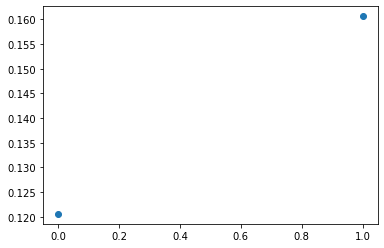

In [150]:
import matplotlib.pyplot as plt
plt.scatter([0,1], 
            time_series_df[['Cosine_similarity(w_t_reference-last,w_t0)',
                           'Cosine_similarity(w_t_reference-last,w_t1)'
                           ]].iloc[0])
plt.show()

I rearrange the dataframe for visualization:

In [151]:
time_series_df.columns

Index(['Word', 'Frequency_t_reference-last', 'Frequency_t0',
       'Cosine_similarity(w_t_reference-last,w_t0)', 'interval-0',
       'Frequency_t1', 'Cosine_similarity(w_t_reference-last,w_t1)',
       'interval-1', 'Frequency_t2',
       'Cosine_similarity(w_t_reference-last,w_t2)', 'interval-2'],
      dtype='object')

In [290]:
time_series_df.head()

,Word,Frequency_t_reference-last,Frequency_t0,"Cosine_similarity(w_t_reference-last,w_t0)",interval-0,Frequency_t1,"Cosine_similarity(w_t_reference-last,w_t1)",interval-1,Frequency_t2,"Cosine_similarity(w_t_reference-last,w_t2)",interval-2
0,occultum,svd1 0.000611 svd2 -0.000413 svd3 ...,0 0.049388 1 -0.053028 2 -0.04306...,0.120571,0,0 0.057747 1 -0.003498 2 0.01481...,0.160628,1,svd1 0.000611 svd2 -0.000413 svd3 ...,1,2
1,vitellius,svd1 0.013795 svd2 -0.030046 svd3 ...,0 0.008974 1 -0.207092 2 -0.01823...,0.052794,0,0 0.011762 1 -0.024718 2 0.02160...,0.280230,1,svd1 0.013795 svd2 -0.030046 svd3 ...,1,2
2,densitas,svd1 0.009988 svd2 -0.024317 svd3 ...,0 -0.000458 1 -0.000823 2 -0.00051...,0.093131,0,0 0.005619 1 -0.011434 2 0.03467...,0.029247,1,svd1 0.009988 svd2 -0.024317 svd3 ...,1,2
3,helena,svd1 0.004748 svd2 -0.006913 svd3 ...,0 -0.000169 1 0.002112 2 0.00086...,0.263685,0,0 0.037712 1 -0.035254 2 0.07296...,0.343416,1,svd1 0.004748 svd2 -0.006913 svd3 ...,1,2
4,otus,svd1 0.032419 svd2 -0.571639 svd3 ...,0 0.096003 1 -0.016870 2 0.04573...,0.202788,0,0 0.016564 1 -0.201183 2 -0.01869...,0.294229,1,svd1 0.032419 svd2 -0.571639 svd3 ...,1,2


In [291]:
#time_series_df1 = pd.DataFrame(columns=['Time_interval', 'Cosine_sim', 'Word'])
time_series_df1 = pd.DataFrame()
for index, row in time_series_df.iterrows():
    #print(row['interval-0'], row['Cosine_similarity(w_t_reference-last,w_t0)'])
    
    #temp = pd.DataFrame(
    #    {
    #        'Time_interval': row['interval-0'],
    #        'Cosine_sim': row['Cosine_similarity(w_t_reference-last,w_t0)'],
    #        'Word': row['Word']
    #    }
    #)
    #print([row['interval-0'],row['Cosine_similarity(w_t_reference-last,w_t0)'],row['Word']])
    #print(pd.DataFrame(
    #    [row['interval-0'],row['Cosine_similarity(w_t_reference-last,w_t0)'],row['Word']]))
    time_series_df1 = pd.concat([time_series_df1, pd.DataFrame(
        [row['interval-0'],row['Cosine_similarity(w_t_reference-last,w_t0)'],row['Word']]).transpose()])
    time_series_df1 = pd.concat([time_series_df1, pd.DataFrame(
        [row['interval-1'],row['Cosine_similarity(w_t_reference-last,w_t1)'],row['Word']]).transpose()])
    #print(time_series_df1)

time_series_df1.columns = ['Time_interval', 'Cosine_sim', 'Word']
time_series_df1.head()

,Time_interval,Cosine_sim,Word
0,0,0.120571,occultum
0,1,0.160628,occultum
0,0,0.052794,vitellius
0,1,0.28023,vitellius
0,0,0.093131,densitas


Print to output file:

In [292]:
time_series_df1.to_csv(os.path.join('.', 'semantic_change1_'+str(size_interval)+'_allwords.csv'), index=None) 

In [294]:
time_series_df_socpol = time_series_df[time_series_df['Word'].isin(socio_political_terms)]
time_series_df_socpol.to_csv(os.path.join('.', 'semantic_change_'+str(size_interval)+'_socpolwords.csv'), index=None) 
time_series_df_socpol.head()

,Word,Frequency_t_reference-last,Frequency_t0,"Cosine_similarity(w_t_reference-last,w_t0)",interval-0,Frequency_t1,"Cosine_similarity(w_t_reference-last,w_t1)",interval-1,Frequency_t2,"Cosine_similarity(w_t_reference-last,w_t2)",interval-2
411,senatus,svd1 0.065498 svd2 -0.001436 svd3 ...,0 -0.012122 1 -0.016958 2 0.05848...,0.274419,0,0 0.016866 1 -0.023677 2 0.03499...,0.418224,1,svd1 0.065498 svd2 -0.001436 svd3 ...,1,2
412,pontifex,svd1 0.113578 svd2 -0.010844 svd3 ...,0 0.024334 1 -0.010400 2 0.03629...,0.185401,0,0 0.140611 1 -0.024573 2 0.08172...,0.317837,1,svd1 0.113578 svd2 -0.010844 svd3 ...,1,2
667,natio,svd1 0.047709 svd2 -0.014882 svd3 ...,0 0.059384 1 -0.013836 2 0.05054...,0.237966,0,0 0.054603 1 -0.019739 2 0.06419...,0.313661,1,svd1 0.047709 svd2 -0.014882 svd3 ...,1,2
728,populus,svd1 0.007505 svd2 -0.011638 svd3 ...,0 -0.012576 1 -0.008453 2 -0.00496...,0.451906,0,0 0.082334 1 -0.013940 2 0.07306...,0.544186,1,svd1 0.007505 svd2 -0.011638 svd3 ...,1,2
2186,potestas,svd1 0.016537 svd2 -0.155772 svd3 ...,0 0.019740 1 -0.161531 2 0.04426...,0.521042,0,0 0.029537 1 -0.126610 2 0.04418...,0.595045,1,svd1 0.016537 svd2 -0.155772 svd3 ...,1,2
2477,nobilitas,svd1 0.024189 svd2 -0.005187 svd3 ...,0 0.057578 1 -0.016753 2 0.01706...,0.204607,0,0 0.093876 1 -0.024129 2 0.03773...,0.174155,1,svd1 0.024189 svd2 -0.005187 svd3 ...,1,2
2709,civitas,svd1 0.016349 svd2 -0.018878 svd3 ...,0 0.023874 1 -0.092846 2 0.05075...,0.430484,0,0 0.102652 1 -0.018003 2 0.07534...,0.579252,1,svd1 0.016349 svd2 -0.018878 svd3 ...,1,2
3578,regnum,svd1 0.006465 svd2 -0.009330 svd3 ...,0 -0.011890 1 -0.013459 2 0.01627...,0.443796,0,0 0.007740 1 -0.016413 2 0.03652...,0.621106,1,svd1 0.006465 svd2 -0.009330 svd3 ...,1,2
5128,consilium,svd1 0.028009 svd2 -0.012521 svd3 ...,0 0.072711 1 -0.069033 2 0.04910...,0.469117,0,0 0.073369 1 -0.024608 2 0.03378...,0.547312,1,svd1 0.028009 svd2 -0.012521 svd3 ...,1,2
5221,dux,svd1 0.081850 svd2 -0.011585 svd3 ...,0 0.053178 1 -0.027974 2 0.03372...,0.435687,0,0 0.013695 1 -0.025847 2 0.04841...,0.528934,1,svd1 0.081850 svd2 -0.011585 svd3 ...,1,2


In [295]:
time_series_df1_socpol.dtypes

index             object
Time_interval    float64
Cosine_sim        object
Word              object
dtype: object

In [296]:
time_series_df1_socpol.loc["Time_interval"] = pd.to_numeric(time_series_df1_socpol.reset_index()["Time_interval"], downcast='integer')

In [193]:
time_series_df1_socpol.head()

,Time_interval,Cosine_sim,Word
0,0.0,0.274419,senatus
0,1.0,0.418224,senatus
0,0.0,0.185401,pontifex
0,1.0,0.317837,pontifex
0,0.0,0.237966,natio


In [297]:
time_series_df1_socpol.loc["Cosine_sim"] = pd.to_numeric(time_series_df1_socpol.reset_index()["Cosine_sim"], downcast='float')
time_series_df1_socpol.head()

,index,Time_interval,Cosine_sim,Word
0,0,0.0,0.274419,senatus
1,0,1.0,0.418224,senatus
2,0,0.0,0.185401,pontifex
3,0,1.0,0.317837,pontifex
4,0,0.0,0.237966,natio


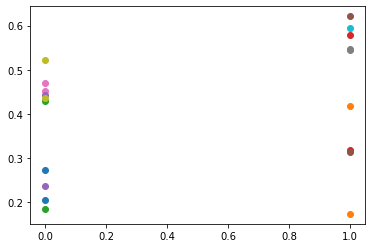

In [298]:
import matplotlib.pyplot as plt
for i in range(len(socio_political_terms)):
    plt.scatter(time_series_df1_socpol[['Time_interval']].iloc[i], 
            time_series_df1_socpol[['Cosine_sim']].iloc[i])
plt.show()

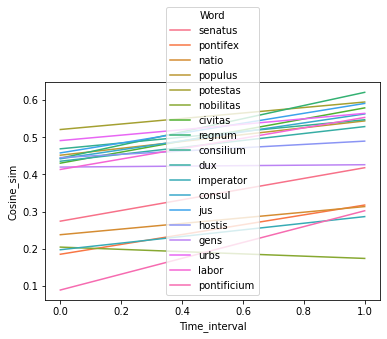

In [299]:
import seaborn as sns
time_series_df1_socpol = time_series_df1_socpol.reset_index()
#sns.lmplot('Time_interval', 'Cosine_sim', data=time_series_df_socpol, hue='Word', fit_reg=False)
sns.lineplot(x='Time_interval', y='Cosine_sim', data=time_series_df1_socpol, hue='Word', legend="full")
plt.show()

# Finished here

# Experimenting

Let's test if `scipy`'s orthogonal_procrustes yields similar results to those obtained with the script.

In [ ]:
from scipy.linalg import orthogonal_procrustes # https://docs.scipy.org/doc/scipy/reference/generated/scipy.linalg.orthogonal_procrustes.html#rb53e47558d72-1
import numpy as np
test = orthogonal_procrustes(np.array(models_dfs[0].loc[common_vocab]).T, np.array(models_dfs[2].loc[common_vocab]).T)

In [ ]:
test[0].shape # Solution. The test[1] stores the sum of singular values
test_procrustes = pd.DataFrame(test[0])

In [ ]:
test_procrustes.head()

In [ ]:
models_dfs_aligned[0].head()

In [ ]:
# Finished HERE

For reference: the structure of wordspace objects and how to access them.

In [ ]:
#models[0][0].rx2('rows').rx2("term")

#print("Let's inspect a model: ", [ print(i) for i in models[0] ] )
#print("Let's inspect a model: ", [ len(i) for i in models[1] ] )
#print(models[1][0])
# weighted = models[0][0]
# weighted reduced = models[0][1]

#print(models[0][0]) #weighted matrix

#print(models[0][0][0]) #sparse Matrix of class "dgCMatrix"
#same as: models[0][0].rx2('M') RAW!
#print(models[0][0][1]) #term - nnzero - f
#same as: models[0][0].rx2('rows')
#print(models[0][0][2]) #term - nnzero - f
#same as: models[0][0].rx2('cols')
#print(models[0][0][3]) # $N, $locked
#same as: models[0][0].rx2('globals
#print(models[0][0][4]) # sparse Matrix of class "dgCMatrix"
#same as: models[0][0].rx2('S') WEIGHTED!

#print(models[0][1]) # reduced matrix
#print(len(models[0][1])) # reduced matrix length

#print(list(models[0][0].rx2('cols').rx2("term"))[0:10])
#list(models[0][0].rx2('cols')[0:10])
#print(list(models[0][0].rx2('rows').rx2("term"))[0:10])
#list(models[0][0].rx2('rows')[0:10])

#print(list(models[0].rx2('M')))